# Testing Tenor Log Mel Spectrogram with Convolutional Neural Network

Here we test a convolutional neural network on log Mel spectrogram data extracted from our WAV samles. Each log Mel spectrogram has 96 x 96 = 9,216 features, where 96 is the number of frequency bands, and 96 is the number of time slices (collections of 2,297 raw samples). So this is a lot of data.

Upstream from this notebook we extracted these features and saved them as pickles, then we read all the pickles and aggregated them into a Pandas DataFrame, again saved as a pickle. Finally, with the imported `_tenor_lms` (below) we read from this pickle, filter and reshape the data as needed, and then we scale data using `sklearn.preprocessing.StandardScaler`. At this point, data are ready to read into our notebook.

In this notebook we define, train, and test a CNN with these log Mel spectrogram data as input.

In [3]:
import os
import time

import pandas as pd
import matplotlib.pyplot as plt
from keras.callbacks import TensorBoard, EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, \
    Conv2D, MaxPooling2D, GlobalMaxPooling2D, LeakyReLU
from keras.metrics import AUC, Recall
# from keras.initializers import GlorotUniform
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from _common import NUM_LABEL_COLS, RANDOM_SEED
from _tenor_lmsc import TEST_SIZE, VALIDATION_SIZE, \
    BANDS, TIME_SLICES, master, lmss, data, target
# Note that records are read from pickle, selected, filtered,
# and scaled with `sklearn.preprocessing.StandardScaler` 
# in `_tenor_lmsc.py`.

In [4]:
x_train, x_test, y_train, y_test = \
     train_test_split(data, target,
                      test_size=TEST_SIZE,
                      random_state=RANDOM_SEED)

In [5]:
# Reshape for input to 2D convolutional layer
x_train = x_train.reshape(x_train.shape[0], BANDS, TIME_SLICES, 1)
x_test = x_test.reshape(x_test.shape[0], BANDS, TIME_SLICES, 1)

# Train the CNN
This may take between 5 and 7 minutes per epoch

# HAN et al. adapted for our data

In [11]:
NUM_EPOCHS = 24
BATCH_SIZE = 32
INPUT_SHAPE = (BANDS, TIME_SLICES, 1)

# See: https://keras.io/api/callbacks/early_stopping/
early_stopping = EarlyStopping(monitor='val_recall', patience=4)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), input_shape=INPUT_SHAPE))
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(32, kernel_size=(3, 3)))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3)))
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(64, kernel_size=(3, 3)))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(128, kernel_size=(3, 3)))
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(128, kernel_size=(3, 3)))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(3, 3)))
# model.add(Dropout(0.25))
# model.add(Conv2D(256, kernel_size=(3, 3), activation="relu"))
# model.add(Conv2D(256, kernel_size=(3, 3), activation="relu"))
model.add(GlobalMaxPooling2D())
model.add(Dense(1024))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', 
              metrics=[Recall(name='recall'), 'accuracy'])  # , AUC(name='auc')
history = model.fit(x_train, y_train, epochs=NUM_EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    validation_split=VALIDATION_SIZE,
                    callbacks=[early_stopping])  # tensorboard_cb, 

Train on 3620 samples, validate on 906 samples
Epoch 1/24
3620/3620 [==============================] - 71s 20ms/step - loss: 0.4965 - recall: 0.7764 - accuracy: 0.7652 - val_loss: 0.3790 - val_recall: 0.9117 - val_accuracy: 0.8333
Epoch 2/24
3620/3620 [==============================] - 68s 19ms/step - loss: 0.3486 - recall: 0.8494 - accuracy: 0.8575 - val_loss: 0.2424 - val_recall: 0.8542 - val_accuracy: 0.9128
Epoch 3/24
3620/3620 [==============================] - 67s 18ms/step - loss: 0.2512 - recall: 0.8953 - accuracy: 0.9050 - val_loss: 0.2615 - val_recall: 0.8563 - val_accuracy: 0.9117
Epoch 4/24
3620/3620 [==============================] - 68s 19ms/step - loss: 0.2275 - recall: 0.9101 - accuracy: 0.9122 - val_loss: 0.2025 - val_recall: 0.8912 - val_accuracy: 0.9260
Epoch 5/24
3620/3620 [==============================] - 67s 19ms/step - loss: 0.2162 - recall: 0.9218 - accuracy: 0.9180 - val_loss: 0.1877 - val_recall: 0.9199 - val_accuracy: 0.9316
Epoch 6/24
3620/3620 [===========

In [12]:
loss, recall, accuracy = model.evaluate(x_test, y_test)
print('Recall: %.2f' % (recall * 100))
print('Accuracy: %.2f' % (accuracy * 100))
# Recall: 95.59 MODEL H
# Accuracy: 93.64 MODEL H

# Recall: 96.08 HAN
# Accuracy: 95.05 HAN

1132/1132 [==============================] - 4s 4ms/step
Recall: 96.08
Accuracy: 95.05


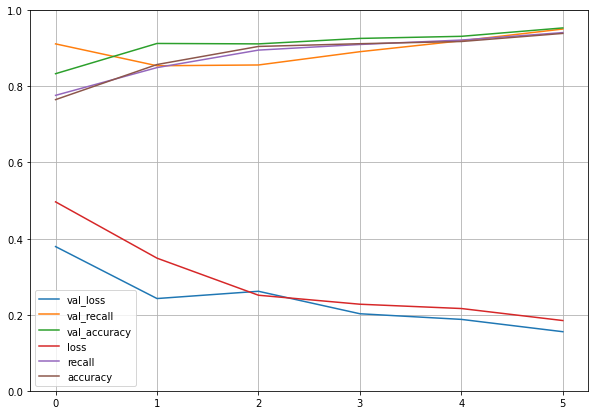

In [13]:
# history is a keras.callbacks.callbacks.History object
pd.DataFrame(history.history).plot(figsize=(10, 7))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [14]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 94, 94, 32)        320       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 94, 94, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 92, 92, 32)        9248      
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 92, 92, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 28, 28, 64)       

In [15]:
model.save('./keras_models/tenor_cnn/tenor_cnn_HAN.h5')